# Convolutional Neural Network on MNIST Database

In this project, i will use a Convolutional Neural Network to classify handwritten digits from the MNIST database.

***Convolutional Neural Networks (CNNs) :***<br>
CNNs are a specialized type of deep learning model designed for image recognition and classification tasks. Unlike traditional neural networks, CNNs can automatically detect and learn spatial patterns, such as edges, textures, and shapes, from images.
- Convolutional layers: Apply filters to extract features from the image.
- Pooling layers: Reduce the spatial size of feature maps, making computations efficient and reducing overfitting.
- Fully connected layers: Combine the extracted features to classify the image into predefined categories.

***MNIST (Modified National Institute of Standards and Technology) :***<br>
MNIST is a classic benchmark dataset for image classification. It contains 70,000 grayscale images of handwritten digits (0–9), each sized 28×28 pixels. The dataset is divided into 60,000 training images and 10,000 test images.

### Import Required Libraries

Let's start by importing all the necessary libraries for data processing, visualization, and building our model.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

### Data Preparation
I create a transform <code>transf</code> to resize the image (originally 28x28) to 16x16 for faster processing. and convert it to a tensor.

In [2]:
transf = transforms.Compose([transforms.Resize((16, 16)), transforms.ToTensor()])

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transf) #training dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transf) #testing dataset

### Convolutional Neural Network Architecture
I create a Convolutional Network class with two Convolutional layers and one fully connected layer.
Before creating the fully connected layer, we need to know how many features are coming out of the convolutional layers and Pre-determine the size of the final output matrix.<br>
The channel width (output size of a convolution) is calculated as:
$$W_{out}=\frac{W_{in}-K+2P}{S}+1$$
- $W_{in}$ = input width
- K = kernel size
- P = padding
- S = stride

After convolution layer, in max pooling we apply a 2x2 kernel and stride=2 (default for maxpool)<br>
the input shape of this Neural Network is <code>(1,16,16)</code> because MNIST images are resized to <code>16x16</code> pixels, and are grayscale (<code>1</code> channel).

In [3]:
class CNN(nn.Module):
    
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, stride=1, padding=2)
        # output width = (16 - 5 + 2*2) / 1 + 1 = 16
        # output shape = (16,16,16)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        # output width = (16 - 2) / 2 + 1 = 8
        # output shape = (16,8,8)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # output width = (8 - 5+ 2*2) / 1 + 1 = 8
        # output shape = (32,8,8)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # output width = (8 - 2) / 2 + 1 = 4
        # output shape = (32,4,4)

        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
        # input = 32 channels × 4 × 4 pixels = 512 features
        # output= 10 classes (digits 0–9)
    
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x   

### Define the Convolutional Neural Network Classifier, Criterion function, Optimizer


In [4]:
model = CNN(out_1=16, out_2=32) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

# Create a Data Loader for the training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Create a Data Loader for the validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

### Training the model

In [5]:
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            # Resets the calculated gradient value
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            # Calculates the gradient value
            loss.backward()
            # Updates the weight and bias
            optimizer.step()

            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        for x_test, y_test in validation_loader:
            z = model(x_test)
            # The class with the max value
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(3)

### Analyze Results

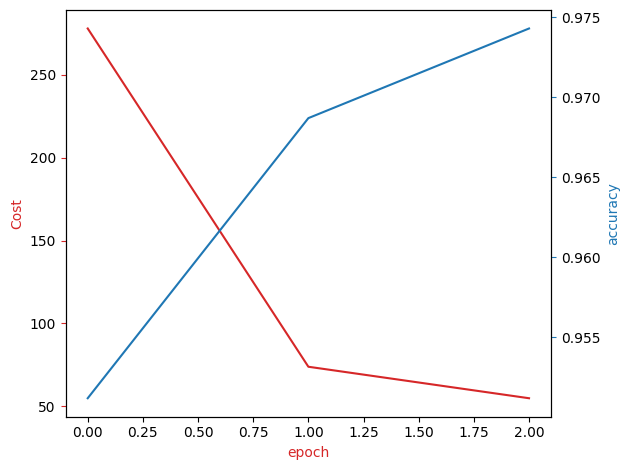

In [6]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

model accuracy

In [7]:
accuracy_list[-1]*100

97.43

save the trained model

In [8]:
torch.save(model.state_dict(), "cnn_mnist_model.pth")
print("Model saved")

Model saved


the first five misclassified samples:

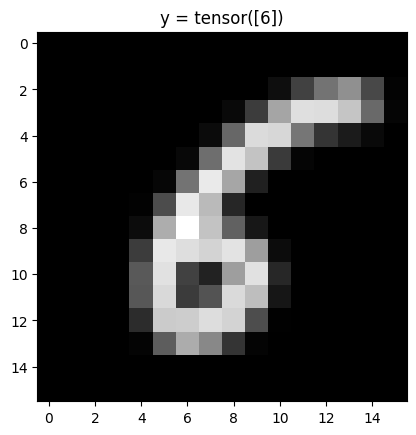

yhat:  tensor([5])


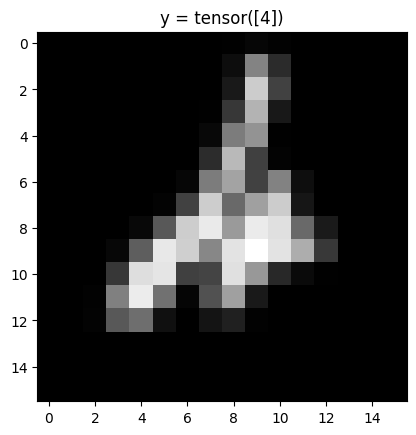

yhat:  tensor([2])


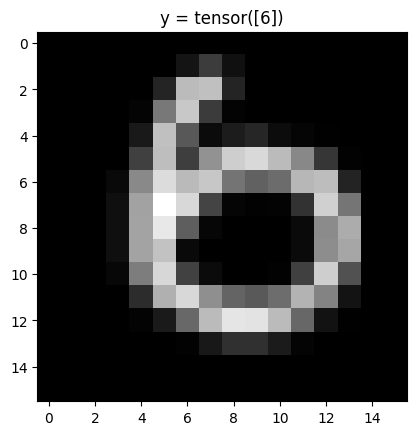

yhat:  tensor([0])


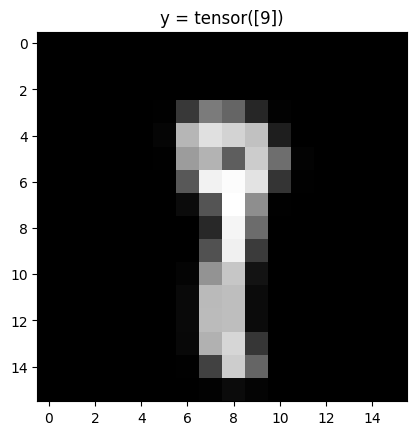

yhat:  tensor([1])


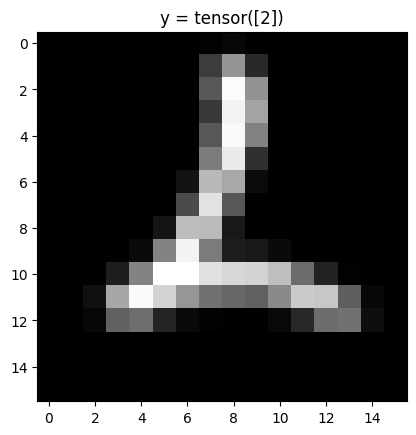

yhat:  tensor([1])


In [14]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        plt.imshow(x.numpy().reshape(16, 16), cmap='gray')
        plt.title('y = '+ str(y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  

## Conclusion

In this project, i built a Convolutional Neural Network to classify handwritten digits from the MNIST dataset. the model achieved high accuracy (97.87) on the validation set.<br>
The loss decreased steadily, indicating effective learning.Most misclassifications occurred on ambiguous digits.

Thanks for following along!

## Credits

Notebook created by [Yasin Pourraisi], September 2025.

**Contact me:**  
- GitHub: [yasinpurraisi](https://github.com/yasinpurraisi)  
- Email: yasinpourraisi@gmail.com  
- Telegram: [yasinprsy](https://t.me/yasinprsy)
